# **EXPERIMENT 4:** Prototype `Research Agent` with Agent Component

# 1. Introduction


*   This experiment prototypes the existing Research Agent using the new Agent and utilizes experimental MultiFileConverter SuperComponent for our use-case.

# 2. Setup Phase

In [1]:
! uv pip install haystack-ai haystack-experimental google-ai-haystack duckduckgo-api-haystack python-dotenv jsonschema trafilatura pypdf markdown-it-py mdit_plain docstring-parser python-pptx python-docx jq pandas openpyxl tabulate

Using Python 3.13.2 environment at: C:\Users\angel\Documents\GitHub\ambitus-ai-models\.venv
Audited 17 packages in 15ms


### Load `.env` file

In [2]:
from dotenv import load_dotenv

load_dotenv() # Load environment variable

True

### Import Packages

In [3]:
from haystack import Pipeline
from haystack.utils import Secret
from haystack.components.agents import Agent 
from haystack.components.fetchers import LinkContentFetcher
from haystack_experimental.super_components.converters import MultiFileConverter
from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiChatGenerator
from duckduckgo_api_haystack import DuckduckgoApiWebSearch
from haystack.components.builders.answer_builder import AnswerBuilder
from haystack.dataclasses import ChatMessage
from haystack.tools.tool import Tool
from haystack.core.super_component import SuperComponent
from haystack.tools import ComponentTool

c:\Users\angel\Documents\GitHub\ambitus-ai-models\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3. Search Tool Setup

### Initializing Tool Pipeline

In [4]:
search_pipe = Pipeline()
""" 
prompt_template = [
    ChatMessage.from_user(
    '''
    According to the following documents:
    {% for document in documents %}
    {{document.content}}
    {% endfor %}
    '''
    )
]

prompt_template2 = [
    ChatMessage.from_user(
    '''
    {% for doc in docs %}
    <search-result url="{{ doc.meta.url }}">
    {{ doc.content|default|truncate(25000) }}
    </search-result>
    {% endfor %}
    '''
    )
]
 """
search_pipe.add_component("search", DuckduckgoApiWebSearch(top_k=10, backend="html"))
search_pipe.add_component("fetcher", LinkContentFetcher(timeout=3, raise_on_failure=False, retry_attempts=2))
search_pipe.add_component("converter", MultiFileConverter())
search_pipe.add_component(
    "prompt_builder", 
    ChatPromptBuilder(
        template=[
            ChatMessage.from_user(
                """
                {% for doc in docs %}
                <search-result url="{{ doc.meta.url }}">
                {{ doc.content|default|truncate(25000) }}
                </search-result>
                {% endfor %}
                {% for document in documents %}
                {{document.content}}
                {% endfor %}
                """
            )
        ],
        variables=["docs", "documents"],
        required_variables=["docs", "documents"]
    )
)

### Connections

In [5]:
search_pipe.connect("search.links", "fetcher.urls")
search_pipe.connect("fetcher.streams", "converter.sources")
search_pipe.connect("converter.documents", "prompt_builder.documents")
search_pipe.connect("search.documents", "prompt_builder.docs")

🚅 Components
  - search: DuckduckgoApiWebSearch
  - fetcher: LinkContentFetcher
  - converter: MultiFileConverter
  - prompt_builder: ChatPromptBuilder
🛤️ Connections
  - search.links -> fetcher.urls (List[str])
  - search.documents -> prompt_builder.docs (List[Document])
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> prompt_builder.documents (List[Document])

### Visualization

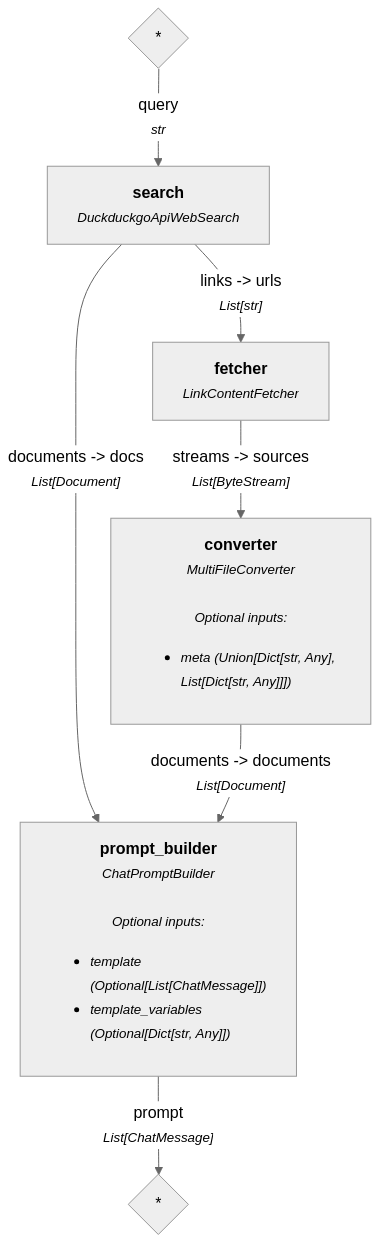

In [6]:
search_pipe.show()

### Tooling

In [7]:
# Wrap in SuperComponent + ComponentTool
search_tool_component = SuperComponent(pipeline=search_pipe)
search_tool = ComponentTool(
    name="webSearch",
    description="Use this tool to search for information on the internet to be added in the research work. Input format: {query: <search query>}",
    component=search_tool_component
)

# 4. Agent Setup

## Utilising LLM: `gemini-2.5-pro-exp-03-25`

### Initialisation

In [12]:
# Build the Chat Generator
chat_generator = GoogleAIGeminiChatGenerator(model="gemini-2.5-pro-exp-03-25")

# Create the Agent
agent = Agent(
    chat_generator=chat_generator,
    tools=[search_tool],
    system_prompt="""
You are a deep research assistant for a target industry/company.
You create comprehensive research reports to answer the user's questions.
Gather data on market trends, competitors, and dynamics.
You must use the 'webSearch'-tool to answer any questions.
You perform multiple searches until you have the information you need to answer the question.
Make sure you research different aspects of the question.
Use markdown to format your response.
When you use information from the websearch results, cite your sources using markdown links.
It is important that you cite accurately.
""",
    exit_conditions=["text"],
    max_agent_steps=100,
    raise_on_tool_invocation_failure=True
)

agent.warm_up()

### Testing Response

In [13]:
# Answer builder
answer_builder = AnswerBuilder()

# Simulate input
query = "Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth."
messages = [ChatMessage.from_user(query)]

# Run agent
agent_output = agent.run(messages=messages)

# Filter replies with valid 'text' only
valid_replies = [msg for msg in agent_output["messages"] if getattr(msg, "text", None)]

answers = answer_builder.run(query=query, replies=valid_replies)

# Print the result
for answer in answers["answers"]:
    print(answer)

GeneratedAnswer(data="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nYou must use the 'webSearch'-tool to answer any questions.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately.\n", query="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth.", documents=[], meta={})
GeneratedAnswer(data="Analyze Zepto's current business, technical,

## Understanding Response

### Raw Response

In [14]:
agent_output["messages"]

[ChatMessage(_role=<ChatRole.SYSTEM: 'system'>, _content=[TextContent(text="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nYou must use the 'webSearch'-tool to answer any questions.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately.\n")], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight ho

In [15]:
from IPython.display import display, Markdown
display(Markdown(answers["answers"][-1].data)) # Print the final answer

Okay, here is a comprehensive analysis of Zepto's current business, technical, and marketing strategies:

**Zepto: Analysis of Business, Technical, and Marketing Strategies**

**Introduction**

Zepto, founded in 2021 by Stanford University dropouts Aadit Palicha and Kaivalya Vohra, has rapidly emerged as a significant player in India's burgeoning quick commerce (Q-commerce) market. Its core proposition revolves around delivering groceries and essentials within an unprecedented 10-minute timeframe. This focus on speed, powered by a robust technological backbone and aggressive marketing, has fueled its meteoric rise, achieving unicorn status in August 2023 [[Source Name](https://www.etretail.com/news/e-tailing/from-startup-to-unicorn-a-look-back-at-zeptos-journey/103191017)] and reaching a valuation of $5 billion by late 2024 [[Source Name](https://startuptalky.com/zepto-success-story/)] [[Source Name](https://zeptonow.com/)] [[Source Name](https://inc42.com/buzz/zepto-to-launch-a-separate-app-for-zepto-cafe-as-popularity-boosts/)] [[Source Name](https://timesofindia.indiatimes.com/business/companies/zepto-to-launch-separate-app-for-cafe-service/articleshow/116005509.cms)]. This report analyzes Zepto's current business, technical, and marketing strategies and their contribution to its growth.

**1. Business Strategy**

*   **Core Model (Quick Commerce & Dark Stores):** Zepto operates on a quick-commerce model centered around its promise of 10-minute delivery [[Source Name](https://startuptalky.com/zepto-business-model-revenue/)] [[Source Name](https://kr-asia.com/zepto-business-model-all-you-need-to-know)]. The backbone of this model is its extensive network of "dark stores" – delivery-only micro-fulfillment centers strategically located in high-demand urban neighborhoods [[Source Name](https://kr-asia.com/zepto-business-model-all-you-need-to-know)] [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)]. These stores are optimized for speed, stocking a curated range of high-demand items (around 2,500+ SKUs initially, now over 25,000) and designed for rapid picking, packing, and dispatch – often within 60 seconds of order placement [[Source Name](https://www.etretail.com/news/e-tailing/from-startup-to-unicorn-a-look-back-at-zeptos-journey/103191017)] [[Source Name](https://www.zeptonow.com/)]. This hyper-local model minimizes delivery distance and time [[Source Name](https://pitchbook.com/profiles/company/494130-61)].
*   **Revenue Streams:** Zepto generates revenue through multiple channels:
    *   **Product Sales Margins:** Procuring goods directly from suppliers allows Zepto to earn margins on product sales [[Source Name](https://startuptalky.com/zepto-business-model-revenue/)] [[Source Name](https://fourweekmba.com/zepto-business-model/)].
    *   **Delivery Fees:** While often offering free delivery above a certain threshold or via subscription (Zepto Pass), Zepto charges delivery fees for smaller orders or during peak times (dynamic pricing) [[Source Name](https://startuptalky.com/zepto-business-model-revenue/)] [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)].
    *   **Advertising & Promotions:** Brands pay Zepto for featured listings, banner ads, and promotions on the app [[Source Name](https://startuptalky.com/zepto-business-model-revenue/)] [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)]. Zepto reported crossing ₹1,000 crore in annualized advertising revenue in late 2024 [[Source Name](https://inc42.com/buzz/zepto-to-launch-a-separate-app-for-zepto-cafe-as-popularity-boosts/)].
    *   **Private Labels:** Zepto has introduced its own private label brands for staples, potentially offering higher margins [[Source Name](https://fourweekmba.com/zepto-business-model/)].
    *   **Zepto Cafe:** This new vertical for 10-minute food and beverage delivery creates an additional revenue stream [[Source Name](https://inc42.com/buzz/zepto-to-launch-a-separate-app-for-zepto-cafe-as-popularity-boosts/)] [[Source Name](https://timesofindia.indiatimes.com/business/companies/zepto-to-launch-separate-app-for-cafe-service/articleshow/116005509.cms)].
    *   **Data Monetization (Potential):** Insights derived from customer data could be monetized by offering analytics services to brands [[Source Name](https://startuptalky.com/zepto-business-model-revenue/)] [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)].
*   **Expansion & Profitability Focus:** Zepto has expanded rapidly, operating hundreds of dark stores (over 600 as of late 2024) across major Indian cities [[Source Name](https://timesofindia.indiatimes.com/business/companies/zepto-to-launch-separate-app-for-cafe-service/articleshow/116005509.cms)]. It is now targeting expansion into Tier 2/3 cities and aims to increase its dark store count significantly (targeting 1,200 by March 2025) [[Source Name](https://startuptalky.com/zepto-success-story/)]. While experiencing massive revenue growth (₹4,454 Cr in FY24, up 120% YoY), Zepto remains loss-making (₹1,249 Cr loss in FY24), though losses decreased slightly [[Source Name](https://startuptalky.com/zepto-business-model-revenue/)] [[Source Name](https://inc42.com/infofeed/quick-commerce-major-zepto-reports-2x-revenue-jump-in-fy24-losses-narrow-marginally/)]. A key strategic focus is achieving profitability (targeting positive EBITDA/PAT soon) by optimizing operations and improving unit economics, with a majority of its dark stores reportedly becoming EBITDA positive [[Source Name](https://startuptalky.com/zepto-success-story/)] [[Source Name](https://inc42.com/infofeed/quick-commerce-major-zepto-reports-2x-revenue-jump-in-fy24-losses-narrow-marginally/)].
*   **IPO Plans:** Zepto is actively preparing for an IPO, potentially in 2025 or 2026. This includes shifting its domicile from Singapore to India, setting up new legal entities, and appointing investment banks (Goldman Sachs, Morgan Stanley, Axis Capital) [[Source Name](https://www.etretail.com/news/e-tailing/from-startup-to-unicorn-a-look-back-at-zeptos-journey/103191017)] [[Source Name](https://startuptalky.com/zepto-success-story/)] [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)]. A recent secondary share sale aims to increase Indian ownership ahead of the IPO [[Source Name](https://www.livemint.com/companies/start-ups/zepto-in-talks-to-facilitate-secondary-share-sale-aims-to-enhance-indian-ownership-pre-ipo-11729647367138.html)].

**2. Technical Strategy**

*   **Technology-Driven Operations:** Technology is fundamental to Zepto's ability to deliver on its 10-minute promise [[Source Name](https://startuptalky.com/zepto-business-model-revenue/)] [[Source Name](https://pitchbook.com/profiles/company/494130-61)]. Its technical strategy focuses on optimizing every stage of the process.
*   **Key Technical Domains:**
    *   **AI and Machine Learning:** Zepto heavily utilizes AI/ML for demand forecasting, inventory management (predicting what to stock where), dark store location optimization (analyzing population density, traffic, etc.), and delivery route optimization [[Source Name](https://fourweekmba.com/zepto-business-model/)] [[Source Name](https://pitchbook.com/profiles/company/494130-61)] [[Source Name](https://www.analyticstep.com/blogs/zeptos-business-model-dark-store-strategy-and-revenue-streams/)]. AI-driven systems also assist in the picking and packing process within dark stores [[Source Name](https://startuptalky.com/zepto-business-model-revenue/)].
    *   **Logistics Optimization:** Sophisticated algorithms calculate the fastest delivery routes in real-time, considering traffic and other factors [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)] [[Source Name](https://pitchbook.com/profiles/company/494130-61)]. GPS technology is integral [[Source Name](https://www.analyticstep.com/blogs/zeptos-business-model-dark-store-strategy-and-revenue-streams/)].
    *   **App Development:** The Zepto app is designed for a seamless, user-friendly experience, enabling quick browsing, ordering, real-time tracking, and personalized recommendations [[Source Name](https://fourweekmba.com/zepto-business-model/)] [[Source Name](https://www.analyticstep.com/blogs/zeptos-business-model-dark-store-strategy-and-revenue-streams/)]. Localization for delivery partners is also a focus [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)].
    *   **Data Analytics:** Zepto leverages data analytics extensively to understand customer behavior, optimize operations, personalize the user experience, and make strategic decisions [[Source Name](https://www.slideteam.net/blog/zepto-bundle-the-sales-and-marketing-strategy-of-zepto.html)] [[Source Name](https://fourweekmba.com/zepto-business-model/)].
*   **Infrastructure & Tools:** The company uses handheld software devices to guide warehouse staff in picking items efficiently [[Source Name](https://kr-asia.com/zepto-business-model-all-you-need-to-know)]. The overall tech stack supports hyper-local inventory management and real-time tracking [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)] [[Source Name](https://pitchbook.com/profiles/company/494130-61)].
*   **Innovation Focus:** Led by CTO and Co-founder Kaivalya Vohra, Zepto continues to invest in its tech stack, looking into areas like automation and edge computing to further enhance efficiency [[Source Name](https://economictimes.indiatimes.com/tech/startups/zepto-eyes-automation-edge-computing-to-better-its-tech-stack-in-2024/articleshow/106193924.cms?from=mdr)]. Tech development is noted as a significant cost component [[Source Name](https://pitchbook.com/profiles/company/494130-61)].

**3. Marketing Strategy**

*   **Unique Selling Proposition (USP) Focus:** Zepto's marketing heavily emphasizes its core USP: 10-minute delivery [[Source Name](https://startuptalky.com/zepto-marketing-strategy/)] [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)]. Free delivery (often available) is another key differentiator highlighted [[Source Name](https://kr-asia.com/zepto-business-model-all-you-need-to-know)].
*   **Target Audience:** The primary target is urban consumers, particularly young adults, students, working professionals, and families who value speed, convenience, and are tech-savvy [[Source Name](https://startuptalky.com/zepto-marketing-strategy/)] [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)].
*   **Channels & Tactics:** Zepto employs a multi-pronged marketing approach:
    *   **Digital Marketing:** Heavy focus on social media platforms like Instagram and Facebook for targeted ads and promotions [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)]. Utilizes "micro-moments" marketing to engage users at points of high purchase intent [[Source Name](https://startuptalky.com/zepto-marketing-strategy/)] [[Source Name](https://digitaluncovered.com/zepto-marketing-strategy-how-this-indian-startup-conquered-quick-commerce/)].
    *   **Branding & Advertising:** Creative ad campaigns (developed with agencies like L&K Saatchi & Saatchi) reinforce the 10-minute promise. Notable campaigns include those during IPL 2022 featuring singers (Shankar Mahadevan, Usha Uthup, Kailash Kher), the "Groceries delivered at Bumrah Speed" campaign with cricketer Jasprit Bumrah, and the "Nahi Milega" campaign featuring the 'Uncle Ji' character [[Source Name](https://startuptalky.com/zepto-marketing-strategy/)] [[Source Name](https://digitaluncovered.com/zepto-marketing-strategy-how-this-indian-startup-conquered-quick-commerce/)]. Out-of-home (OOH) advertising is also used [[Source Name](https://startuptalky.com/zepto-marketing-strategy/)].
    *   **Social Media & Content Marketing:** Known for leveraging meme marketing effectively to engage its young audience and gain organic reach [[Source Name](https://startuptalky.com/zepto-marketing-strategy/)] [[Source Name](https://www.drbrandagency.com/zepto-marketing-strategy/)]. Content includes relatable humor, tips, etc.
    *   **Influencer Marketing:** Collaborates with social media influencers to create authentic content showcasing the service [[Source Name](https://startuptalky.com/zepto-marketing-strategy/)] [[Source Name](https://www.drbrandagency.com/zepto-marketing-strategy/)].
    *   **Referral Programs:** Offers incentives (e.g., 25% discount) for both existing users and new customers they refer, driving cost-effective acquisition [[Source Name](https://startuptalky.com/zepto-marketing-strategy/)] [[Source Name](https://www.drbrandagency.com/zepto-marketing-strategy/)].
    *   **Pricing/Promotions:** Uses competitive pricing and promotional offers (discounts, coupons) to attract and retain customers [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)].
*   **Customer Acquisition & Retention:** The combination of the unique 10-minute delivery promise, free delivery offers, and engaging marketing campaigns has been highly effective in acquiring customers rapidly and achieving high retention rates (reported 60-70% retention) [[Source Name](https://kr-asia.com/zepto-business-model-all-you-need-to-know)] [[Source Name](https://pitchbook.com/profiles/company/494130-61)].

**4. Recent Products and Projects**

*   **Zepto Cafe:** Launched initially within the main app, Zepto Cafe offers 10-minute delivery of beverages (coffee, tea) and snacks (sandwiches, samosas, etc.). Due to rapid scaling (reportedly adding 100+ cafes monthly and handling 30,000+ orders daily), Zepto announced the launch of a separate, dedicated app for Zepto Cafe in late 2024 [[Source Name](https://timesnownews.com/companies/zepto-ceo-aadit-palicha-to-launch-new-zepto-cafe-app-for-10-minute-food-delivery-service-article-115998533)] [[Source Name](https://officechai.com/news/blinkit-launches-10-minute-food-delivery-app-bistro-a-day-after-zepto-cafe-announcement/)]. It operates kitchens within its existing dark store network and aims for significant revenue growth (targeting ₹1,000 Cr ARR by 2026) [[Source Name](https://inc42.com/buzz/zepto-to-launch-a-separate-app-for-zepto-cafe-as-popularity-boosts/)] [[Source Name](https://startuptalky.com/zepto-success-story/)].
*   **Product/Category Expansion:** Beyond core groceries, Zepto has partnered with brands like US Polo Assn (fashion), Park+ (car care), Pescafresh (seafood/meat), and boAt (audio products) for quick delivery, indicating diversification [[Source Name](https://www.linkedin.com/pulse/zepto-business-model-how-does-make-money-tanvir-taj-hedof)] [[Source Name](https://startuptalky.com/zepto-marketing-strategy/)]. Expansion into categories like electronics and pharmacy has been mentioned as a future prospect [[Source Name](https://fourweekmba.com/zepto-business-model/)].
*   **Zepto Pass:** A subscription service offering benefits like free delivery, likely aimed at increasing customer loyalty and order frequency [[Source Name](https://www.drbrandagency.com/zepto-marketing-strategy/)].

**5. Contribution to Growth**

*   **Integrated Strategy:** Zepto's business (dark stores, Q-commerce), technical (AI/ML, logistics optimization), and marketing (10-min promise, branding) strategies are deeply intertwined and mutually reinforcing. The operational model enables the marketing promise, which in turn drives customer acquisition and revenue growth.
*   **Speed as a Differentiator:** The relentless focus on 10-minute delivery, enabled by technology and dark stores, has been the primary growth driver, attracting significant funding and a large customer base (reports mentioned 200% monthly growth previously) [[Source Name](https://startuptalky.com/zepto-business-model-revenue/)] [[Source Name](https://pitchbook.com/profiles/company/494130-61)].
*   **Technological Efficiency:** Investment in technology allows Zepto to manage complex logistics efficiently, scale operations rapidly, optimize costs (crucial for improving unit economics), and enhance customer experience [[Source Name](https://pitchbook.com/profiles/company/494130-61)] [[Source Name](https://www.analyticstep.com/blogs/zeptos-business-model-dark-store-strategy-and-revenue-streams/)].
*   **Effective Marketing & Branding:** Strong branding centered around speed and convenience, coupled with innovative marketing campaigns, has built significant brand awareness and driven customer acquisition in a competitive market [[Source Name](https://startuptalky.com/zepto-marketing-strategy/)] [[Source Name](https://digitaluncovered.com/zepto-marketing-strategy-how-this-indian-startup-conquered-quick-commerce/)].
*   **New Service Expansion (Zepto Cafe):** Diversifying into high-frequency categories like food and beverages through Zepto Cafe represents a significant new growth vector, boosting order values and revenue [[Source Name](https://startuptalky.com/zepto-success-story/)] [[Source Name](https://inc42.com/buzz/zepto-to-launch-a-separate-app-for-zepto-cafe-as-popularity-boosts/)].
*   **Financial Growth:** These strategies have directly contributed to Zepto's rapid revenue growth (doubling in FY24), achieving significant Gross Order Value (reported ~$3B annualized run rate in Jan 2025) [[Source Name](https://www.indianretailer.com/news/zepto-achieves-usd-3-billion-annualized-gov)], and attracting substantial funding at increasing valuations ($5B latest) [[Source Name](https://inc42.com/infofeed/quick-commerce-major-zepto-reports-2x-revenue-jump-in-fy24-losses-narrow-marginally/)]. The focus now is translating this top-line growth into profitability.

**Conclusion**

Zepto's success is built on a clearly defined strategy centered around ultra-fast delivery, enabled by a sophisticated dark store network and advanced technology. Its aggressive marketing has effectively communicated its core value proposition, driving rapid customer adoption and revenue growth. Key technical domains revolve around AI/ML-driven optimization of logistics, inventory, and routing. Recent initiatives like Zepto Cafe demonstrate a push towards diversification and tapping into higher-frequency purchase categories. While achieving profitability remains a key challenge amidst high operational costs and intense competition, Zepto's disciplined execution, strong funding, focus on operational efficiency, and innovative strategies position it as a formidable player likely to continue shaping India's quick commerce landscape as it heads towards a potential IPO.

In [16]:
temp = [msg for msg in agent_output["messages"] if getattr(msg, "result", None)]

In [17]:
print(temp)

[]


In [18]:
agent_output["messages"]

[ChatMessage(_role=<ChatRole.SYSTEM: 'system'>, _content=[TextContent(text="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nYou must use the 'webSearch'-tool to answer any questions.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately.\n")], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight ho